# Build and train a fast.ai model with Amazon SageMaker Notebook instance

## Background

This notebook shows how to build and train a fast.ai based Deep Learning model using an Amazon SageMaker notebook instance, save the model and upload the model artefacts to S3.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
bucket='sagemaker-mcclean-eu-west-1'          # customize to the name of your S3 bucket
model_file_name = 'lhr-summit-demo'           # customize to the name of your model
PATH='data/dogscats/'                         # customize to the relative location of your data folder
key='models/'+model_file_name+'/model.tar.gz' # prefix of the S3 bucket of the model file

In [6]:
import boto3
import re
import os

## Train fastai model locally
Now we will train the fastai CNN model to distinguish between cats and dogs based on lesson 1 of the fast.ai course.

In [7]:
import torch
from fastai.imports import *

In [8]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [9]:
sz=224

In [10]:
torch.cuda.is_available()

True

In [11]:
torch.backends.cudnn.enabled

True

In [12]:
arch=resnet34

In [14]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))

In [15]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 85670890.21it/s]


100%|██████████| 32/32 [00:05<00:00,  6.13it/s]


In [16]:
lrf=learn.lr_find()

 76%|███████▌  | 272/360 [00:06<00:02, 39.59it/s, loss=0.458]


Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

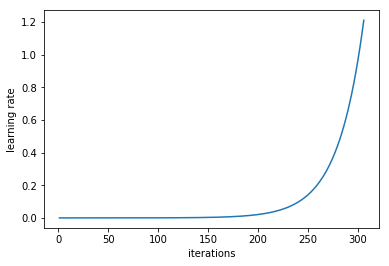

In [17]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

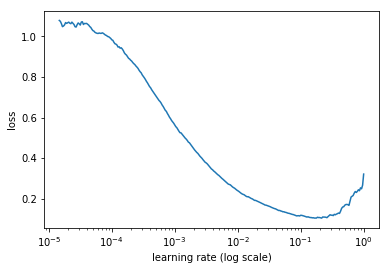

In [18]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

## Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [19]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [20]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [21]:
ims = np.stack([get_augs() for i in range(6)])

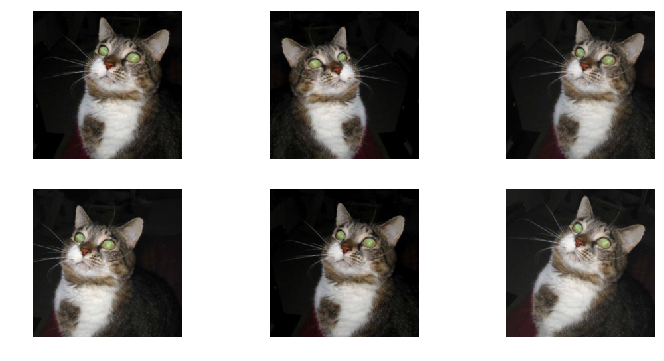

In [22]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [23]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [24]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.048065   0.027298   0.9905    



[array([0.0273]), 0.9905]

In [25]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [26]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.047436   0.02716    0.99      
    1      0.048459   0.026925   0.9895                       
    2      0.044902   0.026724   0.99                         



[array([0.02672]), 0.99]

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [27]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [28]:
lr=np.array([1e-4,1e-3,1e-2])

In [29]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.051123   0.025031   0.9915    
    1      0.041776   0.021245   0.9915                       
    2      0.029277   0.018698   0.9915                       
    3      0.030258   0.021687   0.9895                       
    4      0.020285   0.019002   0.991                        
    5      0.016274   0.018181   0.9915                       
    6      0.016652   0.018311   0.9915                       



[array([0.01831]), 0.9915]

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

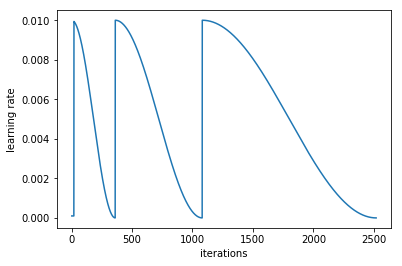

In [30]:
learn.sched.plot_lr()

Now we can save our model so it can be used later by SageMaker using it as a model hosting service.

In [31]:
learn.save(model_file_name)

## Upload fastai model to S3
Now that we have trained a model and saved locally we can upload it plus some extra files to S3.

In [32]:
def get_relative_path(filename):
    s1 = os.path.split(filename)
    p = os.path.split(s1[0])[1]
    return os.path.join(p, s1[1])

In [33]:
def create_dummy_data(src_path, dest_root, sub_dir, num_items=2):
    if not os.path.isdir(dest_root): os.mkdir(dest_root)
    dst_path = os.path.join(dest_root, sub_dir)
    classes = os.listdir(src_path)
    for d in classes:
        if d.startswith('.'): continue
        if not os.path.isdir(dst_path): os.mkdir(dst_path)
        if not os.path.isdir(os.path.join(dst_path, d)): os.mkdir(os.path.join(dst_path, d))
        fnames = glob('{}/{}/*.jpg'.format(src_path, d))
        for i in range(num_items):
            shutil.copyfile(fnames[i], os.path.join(dst_path, get_relative_path(fnames[i])))

In [34]:
create_dummy_data(PATH + "train", PATH + "models/data", "train")
create_dummy_data(PATH + "valid", PATH + "models/data", "valid")

Now we will create a tarfile with the saved model and some dummy images from the train and validation data sets.

In [36]:
!tar czvf data/dogscats/model.tar.gz --exclude='tmp.h5' -C data/dogscats/models/ .

./
./lhr-summit-demo.h5
./data/
./data/train/
./data/train/dogs/
./data/train/dogs/dog.1589.jpg
./data/train/dogs/dog.3600.jpg
./data/train/cats/
./data/train/cats/cat.3863.jpg
./data/train/cats/cat.8246.jpg
./data/valid/
./data/valid/dogs/
./data/valid/dogs/dog.4068.jpg
./data/valid/dogs/dog.2560.jpg
./data/valid/cats/
./data/valid/cats/cat.7384.jpg
./data/valid/cats/cat.11747.jpg


Now we will upload the zipped model and example images to S3.

In [37]:
boto3.client('s3').upload_file(PATH+"model.tar.gz", bucket, key)
print(f"Uploaded model artefacts to s3://{bucket}/{key}")

Uploaded model artefacts to s3://sagemaker-mcclean-eu-west-1/models/lhr-summit-demo/model.tar.gz


## Conclusion

You have seen in this example notebook how to train an example fast.ai model on a SageMaker notebook, save the model and upload it to S3.